## Gerekli kütüphaneleri import et



In [102]:
import numpy as np


## actions listesini oluştur

In [103]:
# Tanıyacağımız işaretler (örnekle başlıyoruz)
actions = np.array([
    'A','B','C',  # Türkçe alfabedeki harfler (Ç,Ğ,İ,Ö,Ş,Ü dahil)
    'MERHABA','TESEKKUR','NASIL_SIN','EVET','HAYIR'
])

print(f"Toplam hareket sayısı: {len(actions)}")
print(actions)


Toplam hareket sayısı: 8
['A' 'B' 'C' 'MERHABA' 'TESEKKUR' 'NASIL_SIN' 'EVET' 'HAYIR']


## Model Kodunu Actions Listesine Göre Güncelleme

In [44]:
from tensorflow.keras import layers, models

# Daha önce tanımladığımız actions dizisi burada kullanılacak
# actions = np.array([...])

model = models.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(30, 1662)),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(actions), activation='softmax')  # çıktı katmanını actions sayısına göre ayarlıyoruz
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 549,704 (2.10 MB)

 Trainable params: 549,704 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

***********************************
***********************************
***********************************
# Adım 3: Video-Temelli Veri Toplama
***********************************
***********************************

In [45]:
#Kütüphaneler
import cv2
import numpy as np
import mediapipe as mp
import os


### Parametreleri Tanımlayın

In [69]:
# ——— Ayarlar ———
label = 'HAYIR'           # Kaydedeceğiniz işaretin adı
num_sequences = 30          # Her işaret için video/sekan sayısı
sequence_length = 30        # Her sekanstaki kare (frame) sayısı

DATA_PATH = os.path.join('MP_Data', label)
#label’i her seferinde farklı işarette (örn. 'A', 'B', 'TESSEKKUR') çalıştırarak değiştirin.


### Klasörleri Oluşturun

In [70]:
# Her sequence için klasör
for seq in range(num_sequences):
    dir_path = os.path.join(DATA_PATH, str(seq))
    os.makedirs(dir_path, exist_ok=True)
    #Çalıştırınca MP_Data/MERHABA/0 … MP_Data/MERHABA/29 klasörleri oluşacak.

### Mediapipe Holistic Kurulumu

In [71]:
mp_holistic = mp.solutions.holistic.Holistic(
    static_image_mode=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
mp_drawing = mp.solutions.drawing_utils


### Video Yakalama ve Landmark Çıkarma

In [72]:
cap = cv2.VideoCapture(0)

for seq in range(num_sequences):
    for frame_num in range(sequence_length):
        ret, frame = cap.read()
        if not ret:
            break

        # RGB’ya çevir ve işle
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = mp_holistic.process(image)

        # Landmark’ları tek bir vektöre dönüştür
        keypoints = []
        # Vücut
        if results.pose_landmarks:
            for lm in results.pose_landmarks.landmark:
                keypoints += [lm.x, lm.y, lm.z, lm.visibility]
        else:
            keypoints += [0]*132   # 33 landmark ×4

        # Sol el
        if results.left_hand_landmarks:
            for lm in results.left_hand_landmarks.landmark:
                keypoints += [lm.x, lm.y, lm.z]
        else:
            keypoints += [0]*63    # 21 landmark ×3

        # Sağ el
        if results.right_hand_landmarks:
            for lm in results.right_hand_landmarks.landmark:
                keypoints += [lm.x, lm.y, lm.z]
        else:
            keypoints += [0]*63

        # (İstersen yüz landmark’larını da ekleyebilirsin)

        # Kaydet
        npy_path = os.path.join(DATA_PATH, str(seq), f"{frame_num}.npy")
        np.save(npy_path, np.array(keypoints))

        # Görüntü ekranda
        cv2.putText(frame, f'{label} {seq}-{frame_num}', (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.imshow('Recording', frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

#Kod çalışırken ekranda “label sekan frame” bilgisi gözükecek.
#q ile erken çıkabilirsiniz; normalde tüm kareleri kaydedecektir.


### Kayıtların Kontrolü


In [73]:
# Örnek: 0. sekansın dosyalarını listele
print(os.listdir(os.path.join(DATA_PATH, '0')))
# İlk .npy dosyasını yükleyip boyutunu kontrol et
arr = np.load(os.path.join(DATA_PATH, '0', '0.npy'))
print(arr.shape)

#print 1662 (4×33 + 3×21 + 3×21) gibi sabit bir boyut göstermeli.


['0.npy', '1.npy', '10.npy', '11.npy', '12.npy', '13.npy', '14.npy', '15.npy', '16.npy', '17.npy', '18.npy', '19.npy', '2.npy', '20.npy', '21.npy', '22.npy', '23.npy', '24.npy', '25.npy', '26.npy', '27.npy', '28.npy', '29.npy', '3.npy', '4.npy', '5.npy', '6.npy', '7.npy', '8.npy', '9.npy']
(258,)


***********************************
***********************************
***********************************
# Adım 4: Modeli Yeniden Eğitme
***********************************
***********************************

In [74]:
import os
import numpy as np
from tensorflow.keras import layers, models, utils
from sklearn.model_selection import train_test_split


### actions Dizisini ve Veri Yolunu Tanımlayın

In [75]:
# 1) Tanımlı hareketler (Adım 2’de oluşturduğunuz liste)
actions = np.array([
    'A','B','C',  # … tüm harfler
    'MERHABA','TESEKKUR','NASIL_SIN','EVET','HAYIR'
])

# 2) Veri klasörü
DATA_PATH = 'MP_Data'

#actions listesinin birebir Adım 2’dekiyle aynı olduğuna emin olun.

### Veriyi Yükleyip X, y Dizilerine Dönüştürme

In [80]:
# Burada her klasör (hareket) için alt klasörleri (sekans) dolaşıp, içindeki .npy dosyalarını okuyoruz:

sequences, labels = [], []

for idx, action in enumerate(actions):
    action_path = os.path.join(DATA_PATH, action)
    # her hareketin sekans numaraları
    for seq in sorted(os.listdir(action_path), key=int):
        window = []
        seq_path = os.path.join(action_path, seq)
        # her kare
        frame_files = sorted(os.listdir(seq_path), key=lambda x: int(x.split('.')[0]))
        for frame_file in frame_files:
            frame_path = os.path.join(seq_path, frame_file)
            res = np.load(frame_path)               # (1662,) vektör
            window.append(res)
        sequences.append(window)                   # (30,1662)
        labels.append(idx)                         # one-hot için indeks

# numpy array’ine çevir
X = np.array(sequences)                          # shape: (num_samples, 30, 1662)
y = utils.to_categorical(labels).astype(int)     # shape: (num_samples, num_actions)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


ValueError: invalid literal for int() with base 10: '0.npy'

### Eğitim ve Test Setine Ayırma

In [77]:
# Veriyi %80 eğitim, %20 test olarak bölüyoruz:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set:  {X_test.shape}, {y_test.shape}")

# stratify=y ile her sınıftan dengeli örnek ayırmış oluruz.

Train set: (192, 30, 258), (192, 8)
Test set:  (48, 30, 258), (48, 8)


### Model Mimarisi Oluşturma

In [81]:
# Aşağıdaki LSTM → Dense mimarisini kullanıyoruz:

model = models.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(30, 258)),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(actions), activation='softmax')
])

model.summary()

#Son katman len(actions) siniflı softmax.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 30, 64)              │          82,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 190,280 (743.28 KB)

 Trainable params: 190,280 (743.28 KB)

 Non-trainable params: 0 (0.00 B)

### Modeli Derleme ve Eğitme

In [82]:
# Compile ve fit:

model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=100,                     # İhtiyaca göre artırabilirsiniz
    batch_size=32,
    validation_data=(X_test, y_test)
)


# Eğitim süresince loss ve accuracy değerlerini izleyin.

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.0969 - loss: 2.1056 - val_accuracy: 0.4375 - val_loss: 1.9062
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3837 - loss: 1.8432 - val_accuracy: 0.4375 - val_loss: 1.6104
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4773 - loss: 1.4860 - val_accuracy: 0.5000 - val_loss: 1.3507
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4666 - loss: 1.2550 - val_accuracy: 0.6458 - val_loss: 1.1198
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5761 - loss: 1.0270 - val_accuracy: 0.6667 - val_loss: 0.9457
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6275 - loss: 0.9242 - val_accuracy: 0.7292 - val_loss: 1.0900
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6832 - loss: 0.7762 - val_accuracy: 0.6875 - val_loss: 0.7049
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7327 - loss: 0.7253 - val_accuracy: 0.7292 - val_loss:

### Eğitim Sonrası Modeli Kaydetme

In [86]:
model.save('tsl_action_model.h5')
print("Model kaydedildi: tsl_action_model.h5")

#Bu dosyayı ileride gerçek-zamanlı tahmin için yükleyeceğiz.

Model kaydedildi: tsl_action_model.h5


### Eğitim Grafiğini Görselleştirme

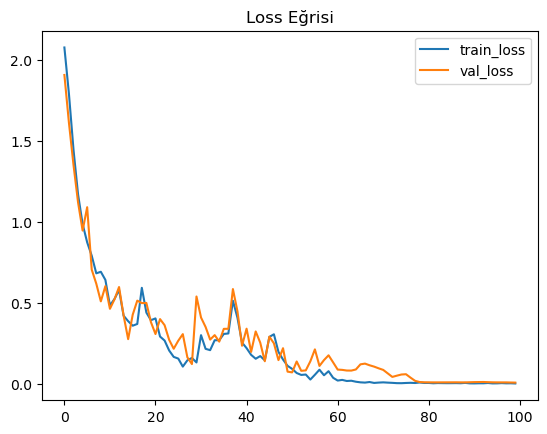

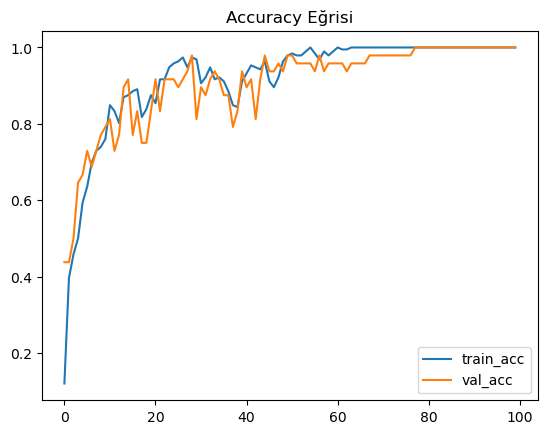

In [87]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss Eğrisi')
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy Eğrisi')
plt.show()


***********************************
***********************************
***********************************
# Adım 5: Tahmin Mantığı ve Cümle oluşturma
***********************************
***********************************

In [88]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model
import mediapipe as mp
from collections import deque


### Modeli ve Ayarları Yükle

In [89]:
# 1) Eğittiğiniz modeli yükleyin
model = load_model('tsl_action_model.h5')

# 2) Hareket listesi (Adım 2’dekilerle aynı)
actions = ['A','B','C','MERHABA','TESSEKKUR','NASIL_SIN','EVET','HAYIR']

# 3) Sıralı kareleri tutmak için pencere boyutu
sequence_length = 30
threshold = 0.7    # olasılık eşiği

# 4) Kaymayı kolaylaştırmak için deque (fixed-length queue)
seq_deque = deque(maxlen=sequence_length)
predictions = deque(maxlen=10)  # son 10 tahmini tutalım
sentence = []                   # oluşturduğumuz metin


### Mediapipe Holistic Kurulumu

In [90]:
mp_holistic = mp.solutions.holistic.Holistic(
    static_image_mode=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)


### Gerçek-Zamanlı Döngü ve Landmark Çıkarma

In [ ]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    # 1) Kareyi RGB’ye çevir ve işle
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = mp_holistic.process(image)

    # 2) Landmark vector oluştur
    keypoints = []
    # Pose
    if results.pose_landmarks:
        for lm in results.pose_landmarks.landmark:
            keypoints += [lm.x, lm.y, lm.z, lm.visibility]
    else:
        keypoints += [0]*132
    # Sol el
    if results.left_hand_landmarks:
        for lm in results.left_hand_landmarks.landmark:
            keypoints += [lm.x, lm.y, lm.z]
    else:
        keypoints += [0]*63
    # Sağ el
    if results.right_hand_landmarks:
        for lm in results.right_hand_landmarks.landmark:
            keypoints += [lm.x, lm.y, lm.z]
    else:
        keypoints += [0]*63

    # 3) deque’ye ekle
    seq_deque.append(keypoints)
    if len(seq_deque) < sequence_length:
        # yeterli kare toplanana kadar bekle
        cv2.putText(frame, 'Hazirlaniyor...', (10,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        cv2.imshow('TSL Tahmin', frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        continue

    # 4) Model tahmini
    res = model.predict(np.expand_dims(seq_deque, axis=0))[0]  # (len(actions),)
    predicted_id = np.argmax(res)
    predicted_action = actions[predicted_id]
    confidence = res[predicted_id]

    # 5) Tahminleri yumuşatma
    predictions.append(predicted_id)
    # Son 10 tahminin hepsi aynı mı?
    if predictions.count(predicted_id) == predictions.maxlen and confidence > threshold:
        # Yeni kelime ekle (art arda eklemeyi engelle)
        if len(sentence) == 0 or sentence[-1] != predicted_action:
            sentence.append(predicted_action)

    # 6) Ekrana yazdır
    cv2.rectangle(frame, (0,0), (640, 40), (245, 117, 16), -1)
    cv2.putText(frame, ' '.join(sentence), (3,30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

    # 7) Görüntüyü göster
    cv2.imshow('TSL Tahmin', frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


***********************************
***********************************
***********************************
# Adım 6: Optimizasyon Test
***********************************
***********************************

### Performans Profili ve Zaman Analizi

#### 1. Kod Profiler Kullanımı

In [95]:
# Python’da cProfile modülünü kullanarak eğitim ve tahmin adımlarının zamanını ölçün:
!python -m cProfile -s time TSL_Project.py
# En çok zaman alan fonksiyonları tespit edin (örn. model.predict, Mediapipe.process).

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Vedat-Dell\anaconda3\Lib\cProfile.py", line 195, in <module>
    main()
  File "C:\Users\Vedat-Dell\anaconda3\Lib\cProfile.py", line 172, in main
    with io.open_code(progname) as fp:
         ^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'TSL_Project.py'


#### 2.Frame Rate (FPS) Ölçümü

In [96]:
#while döngüsüne sayaç ekleyin:
import time
start = time.time()
frame_count = 0

while cap.isOpened():
    # … mevcut kodunuz …
    frame_count += 1
    if frame_count == 30:
        end = time.time()
        print(f"FPS: {30/(end-start):.2f}")
        start, frame_count = time.time(), 0

# 30 kare üzerinden FPS’i ölçün; hedefiniz en az 10–15 FPS.


### Model Optimizasyonu

#### 1.Dropout ve Katman Genişlik Ayarı

%30 dropout’u %20–%40 arasında deneyin.

LSTM(128) veya LSTM(64) gibi nöron sayısını değiştirin.

#### 2.Eğitim Ayarları

batch_size=16 / 32 / 64 ile eğitim tekrarları yapın.

epochs sayısını 50–200 arasında ayarlayıp overfitting’i kontrol edin.

#### 3.Veri Augmentasyon

Tam kareler yerine elleri içeren kareleri kırpıp ölçeklendirin.

Işık koşullarını simüle etmek için parlaklık/kontrast varyasyonları ekleyin:

In [97]:
# Karanlık & parlak versiyon
image_aug = cv2.convertScaleAbs(frame, alpha=1.2, beta=10)


### TensorFlow Lite Dönüşümü

In [98]:
# Mobil veya düşük güçlü cihazlarda hız kazanmak için:

import tensorflow as tf

# Kayıtlı Keras modelini yükle
model = tf.keras.models.load_model('tsl_action_model.h5')

# Converter oluştur
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Dosyayı kaydet
with open('tsl_action_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("TFLite modeli kaydedildi: tsl_action_model.tflite")

# Sonra gerçek-zamanlı script’te tflite_runtime ile yükleyip invoke() edin.


INFO:tensorflow:Assets written to: C:\Users\Vedat-Dell\AppData\Local\Temp\tmpcsjcj71d\assets


INFO:tensorflow:Assets written to: C:\Users\Vedat-Dell\AppData\Local\Temp\tmpcsjcj71d\assets


Saved artifact at 'C:\Users\Vedat-Dell\AppData\Local\Temp\tmpcsjcj71d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 258), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  2347801203280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347801201360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347801203088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347801200208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347801203664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347801201936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347325065744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347325065552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347325065168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347325064976: TensorSpec(shape=(), dtype=tf.resource, name=None)


ConverterError: <unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "sequential_3_1/lstm_6_1/TensorArrayV2_1@__inference_function_33882"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_33933"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "sequential_3_1/lstm_6_1/TensorArrayV2_1@__inference_function_33882"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_33933"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


### Arayüz Performans İyileştirmeleri

#### 1. Video Çözünürlüğünü Düşür

In [99]:
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)


False

#### 2.UI Rendering

OpenCV yerine hafif bir GUI kütüphanesi (ör. PySimpleGUI) deneyin.

Metin güncellemelerini sadece değişiklik olduğunda yeniden çizdirin.



###  Gerçek Koşullarda Test

#### 1.Farklı Işık/Açı Koşulları

Aydınlık ve karanlık ortamda test edin.

Arka plan karmaşık olduğunda doğruluğa bakın.

#### 2.Gerçek Kullanıcı Testi

En az 5 kişi, her işaretten 10 tekrar yaparak test etsin.

Yanlış sınıflandırmaları not ederek confusion matrix çıkarın:

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Axes: >

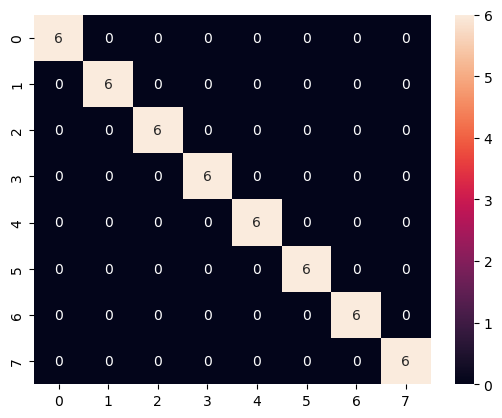

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
